# Agent framework

A framework from Microsoft with support for agentic patterns and full integration with Azure offerings (successor to autogen and semantic-kernal)

## Single agent with tool
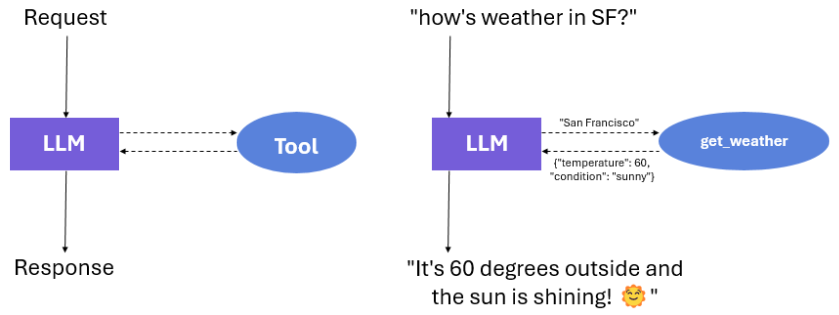

In [1]:
import asyncio
import logging
import os
import random
from typing import Annotated

from agent_framework import ChatAgent
from agent_framework.openai import OpenAIChatClient
from azure.identity.aio import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
from pydantic import Field
from rich import print
from rich.logging import RichHandler

In [2]:
# Setup logging
handler = RichHandler(show_path=False, rich_tracebacks=True, show_level=False)
logging.basicConfig(level=logging.WARNING, handlers=[handler], force=True, format="%(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

client = OpenAIChatClient(
        base_url="https://models.github.ai/inference",
        api_key=os.environ["GITHUB_TOKEN"],
        model_id=os.getenv("GITHUB_MODEL", "openai/gpt-4o"),
    )

In [4]:
def get_weather(
    city: Annotated[str, Field(description="City name, spelled out fully")],
) -> dict:
    """Returns weather data for a given city, a dictionary with temperature and description."""
    logger.info(f"Getting weather for {city}")
    if random.random() < 0.05:
        return {
            "temperature": 72,
            "description": "Sunny",
        }
    else:
        return {
            "temperature": 60,
            "description": "Rainy",
        }

In [5]:
agent = ChatAgent(
    chat_client=client, instructions="You're an informational agent. Answer questions cheerfully.", tools=[get_weather]
)

In [6]:
response = await agent.run("how's weather today in sf?")
print(response.text)

[02/05/26 15:18:54] Getting weather for San Francisco

The weather today in San Francisco is 60°F and rainy. Don't forget your umbrella if you're heading out! 🌧️

#### Single agent with multple tools
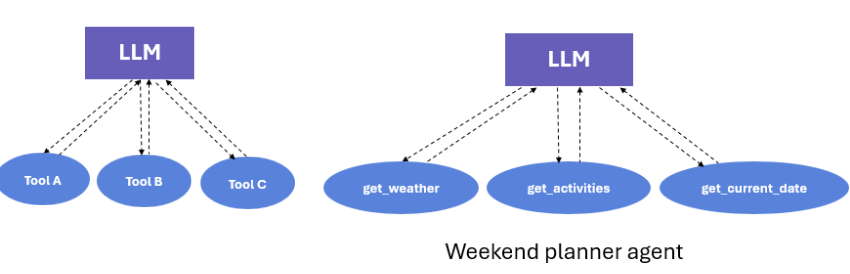

In [7]:
from datetime import datetime

In [8]:
def get_weather(
    city: Annotated[str, Field(description="The city to get the weather for.")],
) -> dict:
    """Returns weather data for a given city, a dictionary with temperature and description."""
    logger.info(f"Getting weather for {city}")
    if random.random() < 0.05:
        return {
            "temperature": 72,
            "description": "Sunny",
        }
    else:
        return {
            "temperature": 60,
            "description": "Rainy",
        }


def get_activities(
    city: Annotated[str, Field(description="The city to get activities for.")],
    date: Annotated[str, Field(description="The date to get activities for in format YYYY-MM-DD.")],
) -> list[dict]:
    """Returns a list of activities for a given city and date."""
    logger.info(f"Getting activities for {city} on {date}")
    return [
        {"name": "Hiking", "location": city},
        {"name": "Beach", "location": city},
        {"name": "Museum", "location": city},
    ]


def get_current_date() -> str:
    """Gets the current date from the system and returns as a string in format YYYY-MM-DD."""
    logger.info("Getting current date")
    return datetime.now().strftime("%Y-%m-%d")

In [9]:
agent = ChatAgent(
    chat_client=client,
    instructions=(
        "You help users plan their weekends and choose the best activities for the given weather. "
        "If an activity would be unpleasant in weather, don't suggest it. Include date of the weekend in response."
    ),
    tools=[get_weather, get_activities, get_current_date], #order does not matter
)

In [10]:
response = await agent.run("what can I do this weekend in San Francisco?")
print(response.text)

[02/05/26 15:18:56] Getting current date

[02/05/26 15:18:57] Getting weather for San Francisco

[02/05/26 15:18:58] Getting activities for San Francisco on 2026-02-07

This weekend, February 7th-8th, the weather in San Francisco is expected to be rainy with a temperature of around 
60°F.

Based on this weather, outdoor activities like hiking or going to the beach might not be ideal due to the rain. 
However, visiting a museum would be a great option to enjoy your weekend indoors while staying dry.

## Supervisor agent with sub-agents
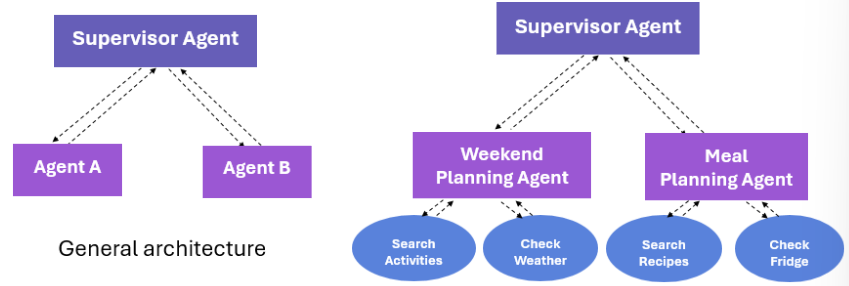

In [11]:
# Sub-agent 1 tools: weekend planning
# ----------------------------------------------------------------------------------


def get_weather(
    city: Annotated[str, Field(description="The city to get the weather for.")],
    date: Annotated[str, Field(description="The date to get weather for in format YYYY-MM-DD.")],
) -> dict:
    """Returns weather data for a given city and date."""
    logger.info(f"Getting weather for {city} on {date}")
    if random.random() < 0.05:
        return {"temperature": 72, "description": "Sunny"}
    else:
        return {"temperature": 60, "description": "Rainy"}


def get_activities(
    city: Annotated[str, Field(description="The city to get activities for.")],
    date: Annotated[str, Field(description="The date to get activities for in format YYYY-MM-DD.")],
) -> list[dict]:
    """Returns a list of activities for a given city and date."""
    logger.info(f"Getting activities for {city} on {date}")
    return [
        {"name": "Hiking", "location": city},
        {"name": "Beach", "location": city},
        {"name": "Museum", "location": city},
    ]


def get_current_date() -> str:
    """Gets the current date from the system (YYYY-MM-DD)."""
    logger.info("Getting current date")
    return datetime.now().strftime("%Y-%m-%d")


weekend_agent = ChatAgent(
    chat_client=client,
    instructions=(
        "You help users plan their weekends and choose the best activities for the given weather. "
        "If an activity would be unpleasant in the weather, don't suggest it. "
        "Include the date of the weekend in your response."
    ),
    tools=[get_weather, get_activities, get_current_date],
)


async def plan_weekend(query: str) -> str:
    """Plan a weekend based on user query and return the final response."""
    logger.info("Tool: plan_weekend invoked")
    response = await weekend_agent.run(query)
    return response.text


In [12]:
# Sub-agent 2 tools: meal planning
# ----------------------------------------------------------------------------------


def find_recipes(
    query: Annotated[str, Field(description="User query or desired meal/ingredient")],
) -> list[dict]:
    """Returns recipes (JSON) based on a query."""
    logger.info(f"Finding recipes for '{query}'")
    if "pasta" in query.lower():
        recipes = [
            {
                "title": "Pasta Primavera",
                "ingredients": ["pasta", "vegetables", "olive oil"],
                "steps": ["Cook pasta.", "Sauté vegetables."],
            }
        ]
    elif "tofu" in query.lower():
        recipes = [
            {
                "title": "Tofu Stir Fry",
                "ingredients": ["tofu", "soy sauce", "vegetables"],
                "steps": ["Cube tofu.", "Stir fry veggies."],
            }
        ]
    else:
        recipes = [
            {
                "title": "Grilled Cheese Sandwich",
                "ingredients": ["bread", "cheese", "butter"],
                "steps": ["Butter bread.", "Place cheese between slices.", "Grill until golden brown."],
            }
        ]
    return recipes


def check_fridge() -> list[str]:
    """Returns a JSON list of ingredients currently in the fridge."""
    logger.info("Checking fridge for current ingredients")
    if random.random() < 0.5:
        items = ["pasta", "tomato sauce", "bell peppers", "olive oil"]
    else:
        items = ["tofu", "soy sauce", "broccoli", "carrots"]
    return items


meal_agent = ChatAgent(
    chat_client=client,
    instructions=(
        "You help users plan meals and choose the best recipes. "
        "Include the ingredients and cooking instructions in your response. "
        "Indicate what the user needs to buy from the store when their fridge is missing ingredients."
    ),
    tools=[find_recipes, check_fridge],
)


async def plan_meal(query: str) -> str:
    """Plan a meal based on user query and return the final response."""
    logger.info("Tool: plan_meal invoked")
    response = await meal_agent.run(query)
    return response.text

In [13]:
# Supervisor agent orchestrating sub-agents
# ----------------------------------------------------------------------------------

supervisor_agent = ChatAgent(
    chat_client=client,
    instructions=(
        "You are a supervisor managing two specialist agents: a weekend planning agent and a meal planning agent. "
        "Break down the user's request, decide which specialist (or both) to call via the available tools, "
        "and then synthesize a final helpful answer. When invoking a tool, provide clear, concise queries."
    ),
    tools=[plan_weekend, plan_meal], #wrap sub-agents as tools 
)

In [14]:
user_query = "my kids want pasta for dinner"
response = await supervisor_agent.run(user_query)
print(response.text)

[02/05/26 15:19:01] Tool: plan_meal invoked

[02/05/26 15:19:02] Finding recipes for 'kids-friendly pasta'

[02/05/26 15:19:03] Checking fridge for current ingredients

A great option for a kid-friendly dinner is "Pasta Primavera." Here's what you'll need:

### Ingredients:
- **Already in your fridge:** Broccoli and carrots.
- **To buy:** Pasta and olive oil.

### Instructions:
1. Cook the pasta as per the package directions.
2. Sauté the broccoli, carrots, or other favorite veggies in olive oil until tender.
3. Combine the sautéed veggies with the cooked pasta and serve.

Let me know if you'd like a variation or alternative recipe!

In [15]:
user_query = "what do i do with the kids this sunday(feb 1st) in KL and what should we have for dinner?"
response = await supervisor_agent.run(user_query)
print(response.text)

[02/05/26 15:19:56] Tool: plan_weekend invoked

[02/05/26 15:19:57] Tool: plan_meal invoked

                    Getting current date

[02/05/26 15:19:58] Finding recipes for 'dinner ideas for kids'

[02/05/26 15:19:59] Checking fridge for current ingredients

                    Getting weather for Kuala Lumpur on 2026-02-01

                    Getting activities for Kuala Lumpur on 2026-02-01

Here’s a plan for your Sunday, February 1st, in Kuala Lumpur, along with a dinner suggestion!

### Activities with Kids
Since it’s expected to rain, indoor activities would be ideal:
1. **Visit a Museum**: Explore fun and educational exhibits suitable for kids in Kuala Lumpur. Museums are a great 
way to keep them entertained and learning while avoiding the rain.

Let me know if you'd like more options or specific recommendations for museums.

### Dinner Idea
How about a classic **Grilled Cheese Sandwich** for dinner? It's simple and kid-friendly. Here's how:
- **Ingredients to buy**: Bread, cheese, butter (you already have olive oil at home).
- **Steps**:
  1. Butter one side of each slice of bread.
  2. Place cheese slices between the non-buttered sides.
  3. Grill the sandwich in a pan until each side is golden brown and the cheese has melted.

Would you like other dinner options or ideas for sides?

## Agentic workflows
Any flow that involves an agent at some point.

Not all calls in the system need an agent because LLM increases the non-determinism of a system and possibility of failure/safety risk

refer to agentframework_workflow.py

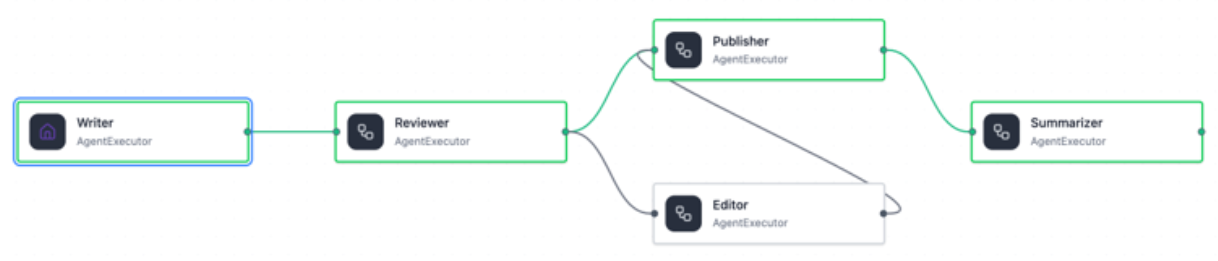
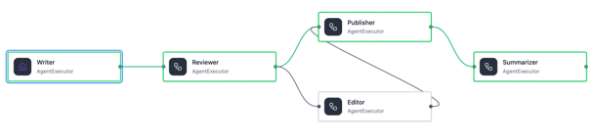